In [19]:
import pandas as pd
final_df = pd.read_csv('../../dataset/final_experiment_avg_df.csv')

In [20]:
final_df = final_df.drop(columns=['experiment_number', 'displacement'])

In [33]:
final_df[final_df["velocity"]==160]

,id,velocity,Period,Cycle_Number,position,smoothed_displacement
0,0,160.0,300.65650,1772.25,0.0,0.000177
1,1,160.0,601.11325,3009.75,0.0,0.000172
2,2,160.0,901.65225,4246.75,0.0,0.000171
3,3,160.0,1202.14075,5483.50,0.0,0.000173
4,4,160.0,1502.75775,6721.00,0.0,0.000173
...,...,...,...,...,...,...
317,317,160.0,47182.42950,194768.75,1.0,0.000165
318,318,160.0,47482.93375,196004.00,1.0,0.000170
319,319,160.0,47783.59375,197242.75,1.0,0.000168
320,320,160.0,48084.02750,198479.50,1.0,0.000165


In [22]:
final_df.to_string(index=False)

'  id  velocity      Period  Cycle_Number  position  smoothed_displacement\n   0     160.0   300.65650       1772.25       0.0               0.000177\n   1     160.0   601.11325       3009.75       0.0               0.000172\n   2     160.0   901.65225       4246.75       0.0               0.000171\n   3     160.0  1202.14075       5483.50       0.0               0.000173\n   4     160.0  1502.75775       6721.00       0.0               0.000173\n   5     160.0  1803.41800       7959.75       0.0               0.000170\n   6     160.0  2104.03525       9196.75       0.0               0.000169\n   7     160.0  2404.66400      10434.50       0.0               0.000169\n   8     160.0  2704.98050      11670.25       0.0               0.000169\n   9     160.0  3005.47275      12907.50       0.0               0.000169\n  10     160.0  3305.94150      14145.25       0.0               0.000167\n  11     160.0  3606.41825      15382.00       0.0               0.000169\n  12     160.0  3906.859

In [23]:
# Specify the velocities you want to filter
target_velocities = [160, 210]

# Filter the dataframe to include only rows with the specified velocities
filtered_df = final_df[final_df['velocity'].isin(target_velocities)]

filtered_df.drop


<bound method DataFrame.drop of       id  velocity       Period  Cycle_Number  position  smoothed_displacement
0      0     160.0    300.65650       1772.25       0.0               0.000177
1      1     160.0    601.11325       3009.75       0.0               0.000172
2      2     160.0    901.65225       4246.75       0.0               0.000171
3      3     160.0   1202.14075       5483.50       0.0               0.000173
4      4     160.0   1502.75775       6721.00       0.0               0.000173
..   ...       ...          ...           ...       ...                    ...
563  563     210.0  35760.03900     194173.75       1.0               0.000168
564  564     210.0  36060.82450     195799.75       1.0               0.000165
565  565     210.0  36361.48050     197423.50       1.0               0.000170
566  566     210.0  36662.09375     199047.50       1.0               0.000167
567  567     210.0  36962.64850     200672.00       1.0               0.000167

[568 rows x 6 colum

In [34]:
import tiktoken

# Choose the encoding based on the model you intend to use
encoding = tiktoken.encoding_for_model("gpt-4o-mini")  # or "text-davinci-003" if using the Davinci model

def count_tokens(final_df, target_velocities):
    filtered_df = final_df[final_df['velocity'].isin(target_velocities)]
    prompt = f"""
    Given the data on velocity and displacement patterns for various experiments, input data is as follows:

    {filtered_df.to_string(index=False)}

    I want you to do data augmentation, you should return a dataframe by reading the data above and generating new data points for velocity from {target_velocities[0]} to {target_velocities[1]}.
    You only generate data points for the new velocity values, I will combine the new data points with the original data points to form the final dataframe.
    Each velocity value should have around 300 data points, start from ~1600 and increment by 1600 each time.

    Make sure its a JSON format, so i can easily convert it to a dataframe.
    """ 

    tokens = encoding.encode(prompt)
    return len(tokens)

# Count the tokens
token_count = count_tokens(final_df, [160, 210])
print(f"Token count: {token_count}")


Token count: 17415


In [ ]:
from openai import OpenAI
import pandas as pd
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

client = OpenAI()



# Access the API key
api_key = os.getenv("OPENAI_API_KEY")


# Define a function to generate synthetic data using OpenAI's API
def generate_synthetic_displacement(final_df, target_velocities):
    filtered_df = final_df[final_df['velocity'].isin(target_velocities)]

    # Construct a prompt using existing data patterns
    prompt = f"""
    Given the data on velocity and displacement patterns for various experiments, input data is as follows:

    {filtered_df.to_string(index=False)}

    I want you to do data augmentation, you should return a dataframe by reading the data above and generating new data points for velocity {sum(target_velocities) / len(target_velocities)}.
    You only generate data points for the new velocity values, I will combine the new data points with the original data points to form the final dataframe.
    Each velocity value should have around 300 data points, start from ~1600 and increment by 1600 each time.

    Make sure its a JSON format, so i can easily convert it to a dataframe.
    """ 

    # Call OpenAI API to complete the prompt
    completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that provides information about displacement values based on velocity and cycle number."},
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            response_format = {
            "type": "json_schema",
            "json_schema": {
                "name": "data_schema",
                "schema": {
                    "type": "object",
                    "properties": {
                        "data": {
                            "type": "array",
                            "items": {
                                "type": "object",
                                "properties": {
                                    "id": {"type": "integer"},
                                    "velocity": {"type": "number"},
                                    "Cycle_Number": {"type": "number"},
                                    "smoothed_displacement": {"type": "number"}
                                },
                                "required": ["id", "velocity", "Cycle_Number", "smoothed_displacement"]
                            }
                        }
                    },
                    "required": ["data"]
                }
            }
        }
    )
    return completion

    # Extract the displacement value from the response
    displacement_text = completion.choices[0].text.strip()
    try:
        displacement = float(displacement_text)
    except ValueError:
        displacement = None  # Handle cases where parsing fails

    return displacement

# # Generate synthetic data for a range of velocities and cycle numbers
# target_velocities = [170, 180, 190]  # Example intermediate velocities
# cycle_numbers = [1772, 3009, 4246]   # Example cycle numbers
# synthetic_data = []

# for velocity in target_velocities:
#     for cycle in cycle_numbers:
#         displacement = generate_synthetic_displacement(velocity, cycle)
#         if displacement is not None:
#             synthetic_data.append({
#                 'velocity': velocity,
#                 'Cycle_Number': cycle,
#                 'displacement': displacement
#             })

# Convert synthetic data to a dataframe
# synthetic_df = pd.DataFrame(synthetic_data)
# print(synthetic_df)


In [40]:
returned_datafram_json = generate_synthetic_displacement(final_df, [160, 210])

In [43]:
result = returned_datafram_json.choices[0].message.content
result

'{"data":[{"id":565,"velocity":160,"Cycle_Number":0,"smoothed_displacement":0.000155},{"id":566,"velocity":160,"Cycle_Number":0,"smoothed_displacement":0.000154},{"id":567,"velocity":160,"Cycle_Number":0,"smoothed_displacement":0.000156},{"id":568,"velocity":160,"Cycle_Number":0,"smoothed_displacement":0.000149},{"id":569,"velocity":160,"Cycle_Number":0,"smoothed_displacement":0.000162},{"id":570,"velocity":160,"Cycle_Number":0,"smoothed_displacement":0.000156},{"id":571,"velocity":160,"Cycle_Number":0,"smoothed_displacement":0.000165},{"id":572,"velocity":160,"Cycle_Number":0,"smoothed_displacement":0.000169},{"id":573,"velocity":160,"Cycle_Number":0,"smoothed_displacement":0.000164},{"id":574,"velocity":160,"Cycle_Number":0,"smoothed_displacement":0.000160},{"id":575,"velocity":160,"Cycle_Number":0,"smoothed_displacement":0.000162},{"id":576,"velocity":160,"Cycle_Number":0,"smoothed_displacement":0.000158},{"id":577,"velocity":160,"Cycle_Number":0,"smoothed_displacement":0.000151},{"

In [44]:
import json
parsed_result = json.loads(result)

generated_df = pd.DataFrame(parsed_result['data'])

generated_df


,id,velocity,Cycle_Number,smoothed_displacement
0,565,160,0,0.000155
1,566,160,0,0.000154
2,567,160,0,0.000156
3,568,160,0,0.000149
4,569,160,0,0.000162
...,...,...,...,...
681,1246,170,4,0.000170
682,1247,170,4,0.000164
683,1248,170,4,0.000170
684,1249,170,4,0.000156


In [45]:
generated_df[generated_df["velocity"]==170]

,id,velocity,Cycle_Number,smoothed_displacement
435,1000,170,0,0.000170
436,1001,170,0,0.000174
437,1002,170,0,0.000176
438,1003,170,0,0.000173
439,1004,170,0,0.000160
...,...,...,...,...
681,1246,170,4,0.000170
682,1247,170,4,0.000164
683,1248,170,4,0.000170
684,1249,170,4,0.000156


In [49]:
# Filter the DataFrame where velocity is 170
mask = generated_df["velocity"] == 170

# Create a sequence starting from 1600, incrementing by 1600
generated_df.loc[mask, "Cycle_Number"] = range(1600, 1600 + 1600 * mask.sum(), 1600)

# Display the modified DataFrame
generated_df[mask]


,id,velocity,Cycle_Number,smoothed_displacement
435,1000,170,1600,0.000170
436,1001,170,3200,0.000174
437,1002,170,4800,0.000176
438,1003,170,6400,0.000173
439,1004,170,8000,0.000160
...,...,...,...,...
681,1246,170,395200,0.000170
682,1247,170,396800,0.000164
683,1248,170,398400,0.000170
684,1249,170,400000,0.000156


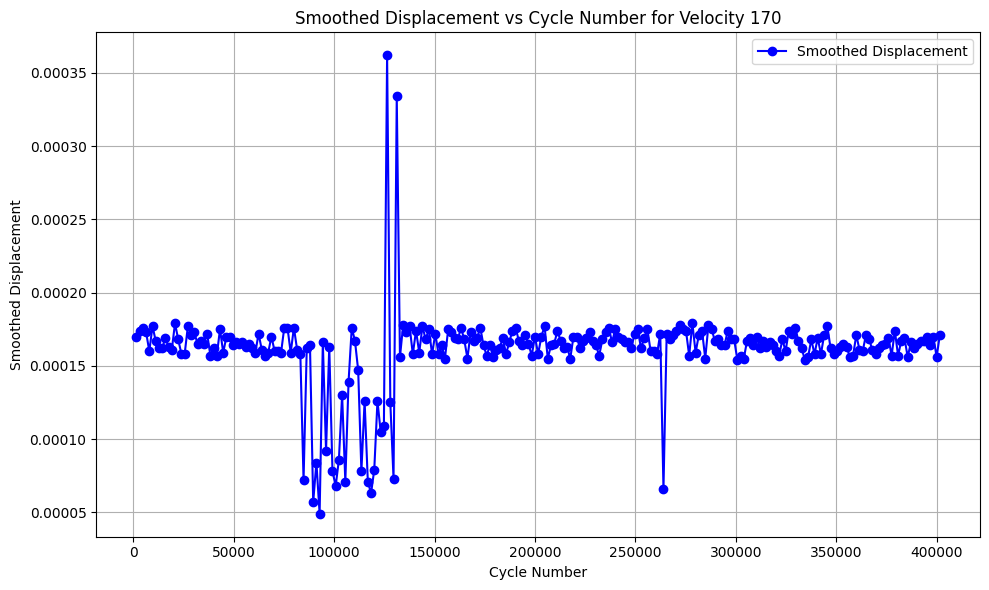

In [50]:
import matplotlib.pyplot as plt

# Plot smoothed_displacement vs Cycle_Number
plt.figure(figsize=(10, 6))
plt.plot(generated_df[mask]["Cycle_Number"], generated_df[mask]["smoothed_displacement"], marker='o', color='b', label='Smoothed Displacement')

# Add labels and title
plt.xlabel('Cycle Number')
plt.ylabel('Smoothed Displacement')
plt.title('Smoothed Displacement vs Cycle Number for Velocity 170')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
